<a href="https://colab.research.google.com/github/SantiagoJusteValverde/SurvivalAnalysis/blob/main/DatosReales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Datos de Bonos_base (prueba2_datos)

In [3]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd

# Autenticar en Google Cloud
auth.authenticate_user()

# Configurar el proyecto
project_id = 'mm-uc3m-catedras'
client = bigquery.Client(project=project_id)





In [4]:
!pip install lifelines
!pip install pysurvival
!pip install scikit-survival
!pip install --upgrade scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches #for custom legends
import seaborn as sns
from lifelines import KaplanMeierFitter #survival analysis library
from lifelines.statistics import logrank_test #survival statistical testing
from IPython.display import Image
from IPython.core.display import HTML

%matplotlib inline

  Using cached pysurvival-0.1.2.tar.gz (4.7 MB)
  Preparing metadata (setup.py) ... done
  Using cached progressbar-2.5.tar.gz (10 kB)
  Preparing metadata (setup.py) ... done
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Using cached scikit_learn-1.4.0-1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: p

In [5]:
# Especificar la consulta SQL
query = """
SELECT *
FROM SURVIVAL_ANALYSIS.zz_aint
"""

# Ejecutar la consulta y descargar el resultado a un DataFrame
df = client.query(query).to_dataframe()

#Preprocesado

In [6]:
# Obtener la forma del DataFrame
shape_info = f"Shape del DataFrame: {df.shape}"

# Obtener la cuenta de valores en la columna 'Churn'
value_counts_info = f"\nConteo de valores en 'Churn':\n{df['churn'].value_counts()}"

# Obtener los tipos de datos del DataFrame
dtypes_info = f"\nTipos de datos del DataFrame:\n{df.dtypes}"

# Imprimir la información combinada
print(shape_info + value_counts_info + dtypes_info)

Shape del DataFrame: (2291555, 10)
Conteo de valores en 'Churn':
Yes    1221392
No     1070163
Name: churn, dtype: int64
Tipos de datos del DataFrame:
account_id                 Int64
init_date                 object
end_date                  object
tenure                     Int64
churn                     object
gasto                    float64
nuevo_customer_id         object
nacionalidad              object
gasto_mensual            float64
comunicaciones_agente      Int64
dtype: object


In [7]:
df_basico = df[['account_id','tenure', 'churn']]
df_basico['tenure'] = df_basico['tenure'] / 30


# Filtrar filas sin valores negativos
df_basico = df_basico[df_basico['tenure'] >= 1]

#Creamos variable para Churn binaria. 0 no ha sucedido, 1 sí ha sucedido
df_basico["churn"] = df_basico["churn"].replace({"Yes": 1, "No": 0})


<ipython-input-7-cb4c86cc62c0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basico['tenure'] = df_basico['tenure'] / 30


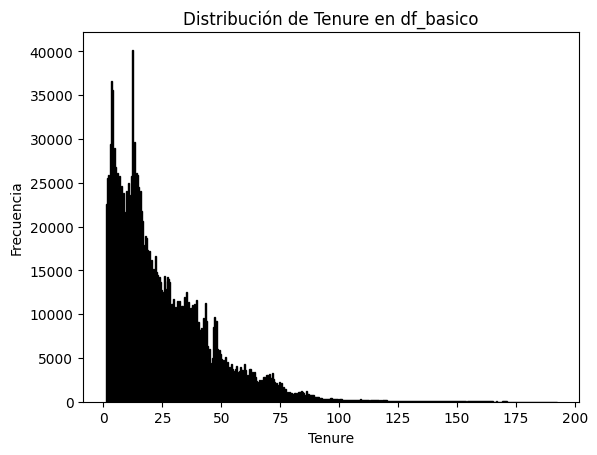

In [8]:
# Seleccionar solo la columna 'Tenure'
tenure_data = df_basico['tenure']

# Crear un histograma
plt.hist(tenure_data, bins='auto', color='skyblue', edgecolor='black')

# Agregar etiquetas y título
plt.xlabel('Tenure')
plt.ylabel('Frecuencia')
plt.title('Distribución de Tenure en df_basico')

# Mostrar el gráfico
plt.show()

In [9]:
# Calcular el rango intercuartílico (IQR)
Q1 = tenure_data.quantile(0.25)
Q3 = tenure_data.quantile(0.75)
IQR = Q3 - Q1

# Definir límites para identificar outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Identificar índices de filas con outliers
indices_outliers = (tenure_data < lower_limit) | (tenure_data > upper_limit)

# Eliminar filas con outliers
df_basico_sin_outliers = df_basico[~indices_outliers]

# Mostrar el DataFrame resultante sin outliers
print("DataFrame sin outliers en 'Tenure':")
print(df_basico_sin_outliers)

DataFrame sin outliers en 'Tenure':
         account_id     tenure  churn
3           7217924       17.3      1
7           5802939  27.233333      1
8           5819389       27.4      1
9           7075427       18.9      1
10          8565494   2.166667      1
...             ...        ...    ...
2291550    13277024  12.233333      1
2291551    10324806       37.9      1
2291552    11105776  30.166667      1
2291553    13047222  13.933333      1
2291554    14102715   6.166667      1

[2067508 rows x 3 columns]


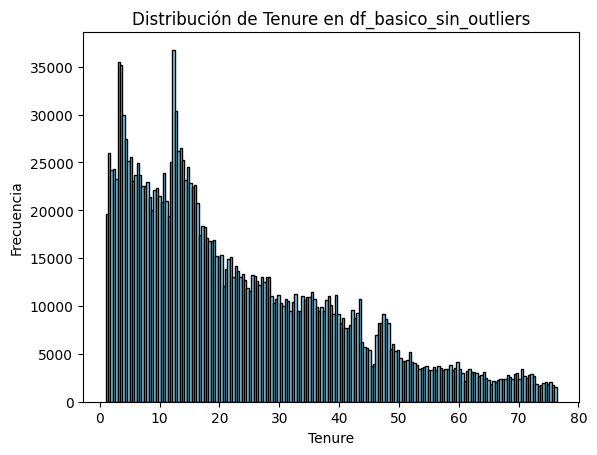

In [10]:
# Seleccionar solo la columna 'Tenure'
tenure_data = df_basico_sin_outliers['tenure']

# Crear un histograma
plt.hist(tenure_data, bins='auto', color='skyblue', edgecolor='black')

# Agregar etiquetas y título
plt.xlabel('Tenure')
plt.ylabel('Frecuencia')
plt.title('Distribución de Tenure en df_basico_sin_outliers')

# Mostrar el gráfico
plt.show()

In [11]:
# Contar la frecuencia de valores en la columna 'Churn'
frecuencia_churn = df_basico_sin_outliers['churn'].value_counts()

# Calcular el porcentaje
porcentaje_churn = frecuencia_churn / len(df_basico_sin_outliers) * 100

# Mostrar el porcentaje
print("Porcentaje de 'Churn' en df_basico_sin_outliers:")
print(porcentaje_churn)

Porcentaje de 'Churn' en df_basico_sin_outliers:
1    50.186456
0    49.813544
Name: churn, dtype: float64


##Variables básicas: Tenure y Churn

In [12]:
kmf = KaplanMeierFitter()
T = df_basico_sin_outliers['tenure'] #duration
C = df_basico_sin_outliers["churn"] #censorship - 1 if death/churn is seen, 0 if censored
kmf.fit(T, event_observed=C)  # or, more succinctly, kmf.fit(T, C)

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 2.06751e+06 total observations, 1.0299e+06 right-censored observations>

Text(0.5, 1.0, 'Función de Supervivencia')

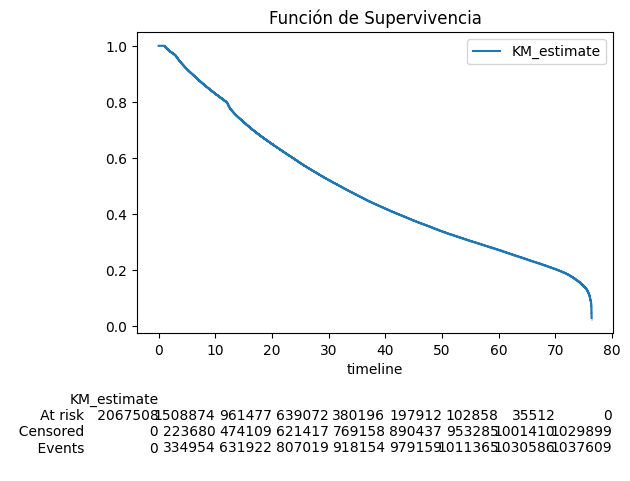

In [13]:
kmf.plot_survival_function(
    at_risk_counts=True
)
plt.title("Función de Supervivencia")

In [14]:
# Calcular el rango intercuartílico (IQR)
Q1 = df_basico_sin_outliers['tenure'].quantile(0.25)
Q3 = df_basico_sin_outliers['tenure'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para identificar outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Identificar índices de filas con outliers
indices_outliers = (df_basico_sin_outliers['tenure'] < lower_limit) | (df_basico_sin_outliers['tenure'] > upper_limit)

# Eliminar filas con outliers
df_basico_sin_outliers2 = df_basico_sin_outliers[~indices_outliers]

# Mostrar el DataFrame resultante sin outliers
print("DataFrame sin outliers en 'Tenure':")
print(df_basico_sin_outliers2)


DataFrame sin outliers en 'Tenure':
         account_id     tenure  churn
3           7217924       17.3      1
7           5802939  27.233333      1
8           5819389       27.4      1
9           7075427       18.9      1
10          8565494   2.166667      1
...             ...        ...    ...
2291550    13277024  12.233333      1
2291551    10324806       37.9      1
2291552    11105776  30.166667      1
2291553    13047222  13.933333      1
2291554    14102715   6.166667      1

[2051319 rows x 3 columns]


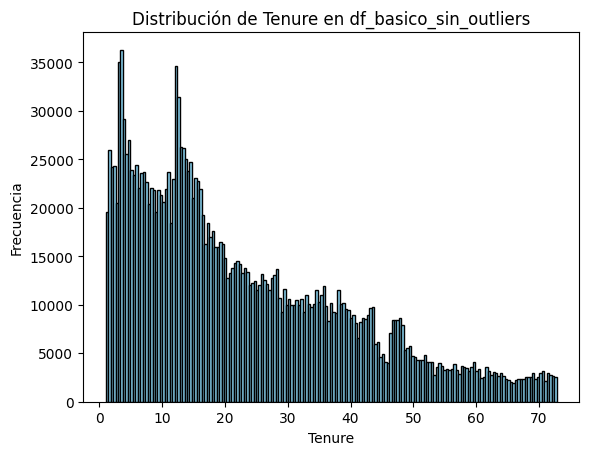

In [15]:
# Seleccionar solo la columna 'Tenure'
tenure_data = df_basico_sin_outliers2['tenure']

# Crear un histograma
plt.hist(tenure_data, bins='auto', color='skyblue', edgecolor='black')

# Agregar etiquetas y título
plt.xlabel('Tenure')
plt.ylabel('Frecuencia')
plt.title('Distribución de Tenure en df_basico_sin_outliers')

# Mostrar el gráfico
plt.show()

In [16]:
# Contar la frecuencia de valores en la columna 'Churn'
frecuencia_churn = df_basico_sin_outliers2['churn'].value_counts()

# Calcular el porcentaje
porcentaje_churn = frecuencia_churn / len(df_basico_sin_outliers2) * 100

# Mostrar el porcentaje
print("Porcentaje de 'Churn' en df_basico_sin_outliers:")
print(porcentaje_churn)

Porcentaje de 'Churn' en df_basico_sin_outliers:
1    50.409858
0    49.590142
Name: churn, dtype: float64


In [17]:
kmf = KaplanMeierFitter()
T = df_basico_sin_outliers2['tenure'] #duration
C = df_basico_sin_outliers2["churn"] #censorship - 1 if death/churn is seen, 0 if censored
kmf.fit(T, event_observed=C)  # or, more succinctly, kmf.fit(T, C)

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 2.05132e+06 total observations, 1.01725e+06 right-censored observations>

Text(0.5, 1.0, 'Función de Supervivencia')

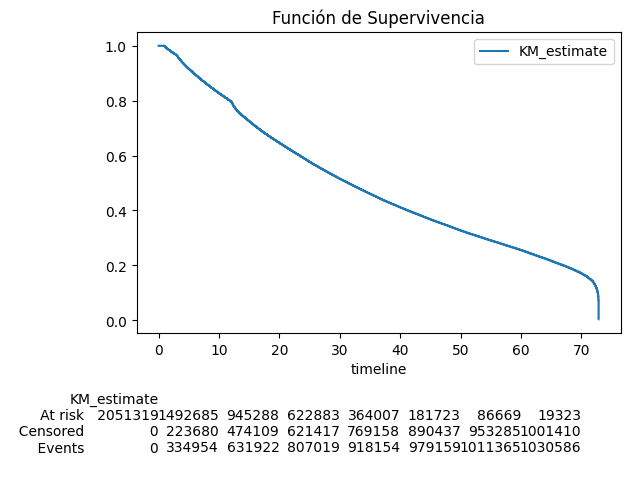

In [18]:
kmf.plot_survival_function(
    at_risk_counts=True
)
plt.title("Función de Supervivencia")

#Más variables

##Gasto total en €

In [19]:
# Especificar la consulta SQL
query = """
SELECT *
FROM SURVIVAL_ANALYSIS.zz_aint
"""

# Ejecutar la consulta y descargar el resultado a un DataFrame
df_2 = client.query(query).to_dataframe()

In [20]:
df_2['extranjero'] = df_2['nacionalidad'].apply(lambda x: 1 if x != 'ESPANA' else 0)

In [21]:
# Obtener la forma del DataFrame
shape_info = f"Shape del DataFrame: {df_2.shape}"

# Obtener la cuenta de valores en la columna 'Churn'
value_counts_info = f"\nConteo de valores en 'Churn':\n{df_2['churn'].value_counts()}"

# Obtener los tipos de datos del DataFrame
dtypes_info = f"\nTipos de datos del DataFrame:\n{df_2.dtypes}"

# Imprimir la información combinada
print(shape_info + value_counts_info + dtypes_info)

Shape del DataFrame: (2291555, 11)
Conteo de valores en 'Churn':
Yes    1221392
No     1070163
Name: churn, dtype: int64
Tipos de datos del DataFrame:
account_id                 Int64
init_date                 object
end_date                  object
tenure                     Int64
churn                     object
gasto                    float64
nuevo_customer_id         object
nacionalidad              object
gasto_mensual            float64
comunicaciones_agente      Int64
extranjero                 int64
dtype: object


In [22]:
df_b2 = df_2[['account_id','tenure', 'churn','gasto','gasto_mensual','nacionalidad','comunicaciones_agente','extranjero']]
df_b2['tenure'] = df_b2['tenure'] / 30


# Filtrar filas sin valores negativos
df_b2 = df_b2[df_b2['tenure'] >= 1]

#Creamos variable para Churn binaria. 0 no ha sucedido, 1 sí ha sucedido
df_b2["churn"] = df_b2["churn"].replace({"Yes": 1, "No": 0})


<ipython-input-22-0b766e4f9e19>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b2['tenure'] = df_b2['tenure'] / 30


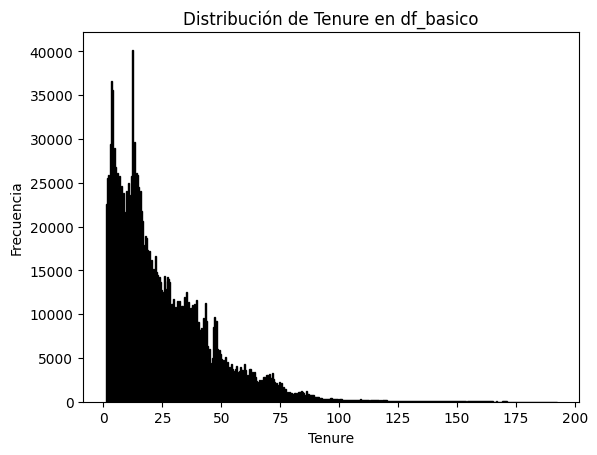

In [23]:
# Seleccionar solo la columna 'Tenure'
tenure_data = df_b2['tenure']

# Crear un histograma
plt.hist(tenure_data, bins='auto', color='skyblue', edgecolor='black')

# Agregar etiquetas y título
plt.xlabel('Tenure')
plt.ylabel('Frecuencia')
plt.title('Distribución de Tenure en df_basico')

# Mostrar el gráfico
plt.show()

In [24]:
# Calcular el rango intercuartílico (IQR)
Q1 = tenure_data.quantile(0.25)
Q3 = tenure_data.quantile(0.75)
IQR = Q3 - Q1

# Definir límites para identificar outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Identificar índices de filas con outliers
indices_outliers = (tenure_data < lower_limit) | (tenure_data > upper_limit)

# Eliminar filas con outliers
df_b2 = df_b2[~indices_outliers]

# Mostrar el DataFrame resultante sin outliers
print("DataFrame sin outliers en 'Tenure':")
print(df_b2)

DataFrame sin outliers en 'Tenure':
         account_id     tenure  churn        gasto  gasto_mensual  \
2           7249934       17.1      1   118.266450       0.230539   
3           6084398  25.866667      1    75.502918       0.097298   
4           7936556   9.066667      1    98.241612       0.361182   
6           7927768        9.2      1    20.729031       0.075105   
7           7202915  17.766667      1    22.470965       0.042159   
...             ...        ...    ...          ...            ...   
2291550    14343094   4.733333      1   184.030000       1.295986   
2291551    12076665  22.266667      1   703.880000       1.053713   
2291552    10951218       31.4      1  1272.600133       1.350956   
2291553    11957385  23.266667      1   697.070000       0.998668   
2291554    14018338   6.666667      1    46.280000       0.231400   

        nacionalidad  comunicaciones_agente  extranjero  
2             ESPANA                      0           0  
3             ESPAN

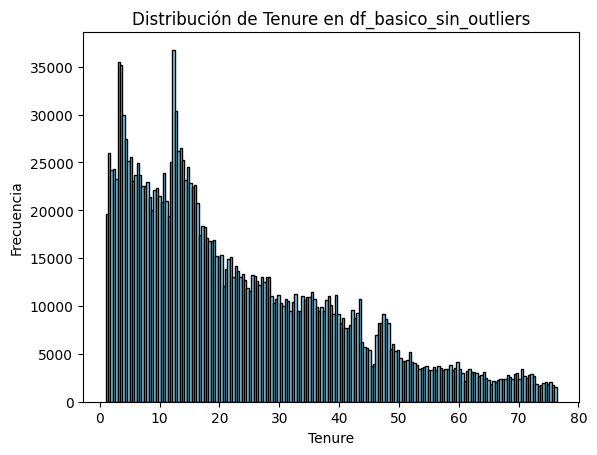

In [25]:
# Seleccionar solo la columna 'Tenure'
tenure_data = df_b2['tenure']

# Crear un histograma
plt.hist(tenure_data, bins='auto', color='skyblue', edgecolor='black')

# Agregar etiquetas y título
plt.xlabel('Tenure')
plt.ylabel('Frecuencia')
plt.title('Distribución de Tenure en df_basico_sin_outliers')

# Mostrar el gráfico
plt.show()

In [26]:
# Contar la frecuencia de valores en la columna 'Churn'
frecuencia_churn = df_b2['churn'].value_counts()

# Calcular el porcentaje
porcentaje_churn = frecuencia_churn / len(df_b2) * 100

# Mostrar el porcentaje
print("Porcentaje de 'Churn' en df_basico_sin_outliers:")
print(porcentaje_churn)

Porcentaje de 'Churn' en df_basico_sin_outliers:
1    50.186456
0    49.813544
Name: churn, dtype: float64


In [27]:
print(df_b2.head())

   account_id     tenure  churn       gasto  gasto_mensual nacionalidad  \
2     7249934       17.1      1  118.266450       0.230539       ESPANA   
3     6084398  25.866667      1   75.502918       0.097298       ESPANA   
4     7936556   9.066667      1   98.241612       0.361182       ESPANA   
6     7927768        9.2      1   20.729031       0.075105       ESPANA   
7     7202915  17.766667      1   22.470965       0.042159       ESPANA   

   comunicaciones_agente  extranjero  
2                      0           0  
3                      0           0  
4                      2           0  
6                      0           0  
7                      0           0  


####GASTO

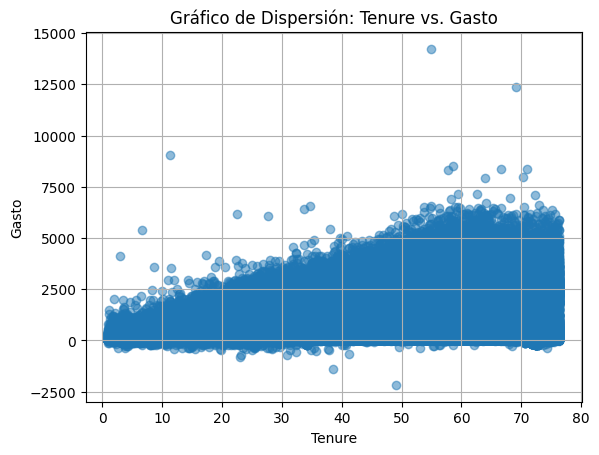

In [28]:

# Crear un gráfico de dispersión (scatter plot)
plt.scatter(df_b2['tenure'], df_b2['gasto'], alpha=0.5)

# Personalizar el gráfico
plt.title('Gráfico de Dispersión: Tenure vs. Gasto')
plt.xlabel('Tenure')
plt.ylabel('Gasto')
plt.grid(True)

# Mostrar el gráfico
plt.show()


In [29]:
import pandas as pd

# Asegúrate de tener tu DataFrame df_2
# Puedes adaptar este código según la estructura real de tu DataFrame

# Calcular el rango intercuartílico (IQR) para 'gasto'
Q1 = df_b2['gasto'].quantile(0.25)
Q3 = df_b2['gasto'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para identificar outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Identificar índices de filas con outliers
indices_outliers = (df_b2['gasto'] < lower_limit) | (df_b2['gasto'] > upper_limit)

# Crear un nuevo DataFrame sin outliers
df_b2 =df_b2[(df_b2['gasto'] >= 0) & (~indices_outliers)]

# Mostrar el nuevo DataFrame sin outliers
print("DataFrame sin outliers en 'gasto':")
print(df_b2)


DataFrame sin outliers en 'gasto':
         account_id     tenure  churn        gasto  gasto_mensual  \
2           7249934       17.1      1   118.266450       0.230539   
3           6084398  25.866667      1    75.502918       0.097298   
4           7936556   9.066667      1    98.241612       0.361182   
6           7927768        9.2      1    20.729031       0.075105   
7           7202915  17.766667      1    22.470965       0.042159   
...             ...        ...    ...          ...            ...   
2291550    14343094   4.733333      1   184.030000       1.295986   
2291551    12076665  22.266667      1   703.880000       1.053713   
2291552    10951218       31.4      1  1272.600133       1.350956   
2291553    11957385  23.266667      1   697.070000       0.998668   
2291554    14018338   6.666667      1    46.280000       0.231400   

        nacionalidad  comunicaciones_agente  extranjero  
2             ESPANA                      0           0  
3             ESPANA

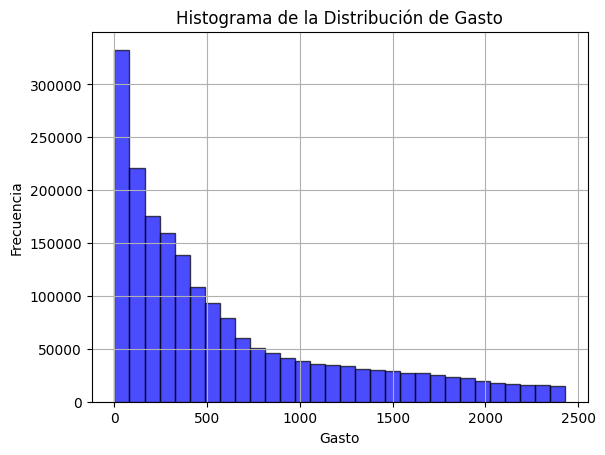

In [30]:
# Crear un histograma de la columna 'gasto'
plt.hist(df_b2['gasto'], bins=30, color='blue', edgecolor='black', alpha=0.7)

# Personalizar el gráfico
plt.title('Histograma de la Distribución de Gasto')
plt.xlabel('Gasto')
plt.ylabel('Frecuencia')
plt.grid(True)

# Mostrar el gráfico
plt.show()

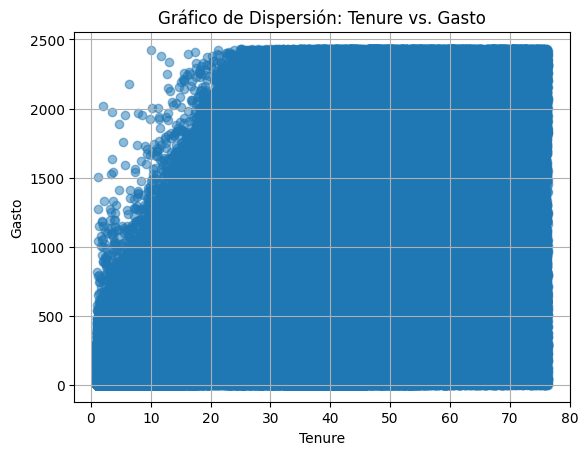

In [31]:
# Crear un gráfico de dispersión (scatter plot)
plt.scatter(df_b2['tenure'], df_b2['gasto'], alpha=0.5)

# Personalizar el gráfico
plt.title('Gráfico de Dispersión: Tenure vs. Gasto')
plt.xlabel('Tenure')
plt.ylabel('Gasto')
plt.grid(True)

# Mostrar el gráfico
plt.show()

####GASTO MENSUAL

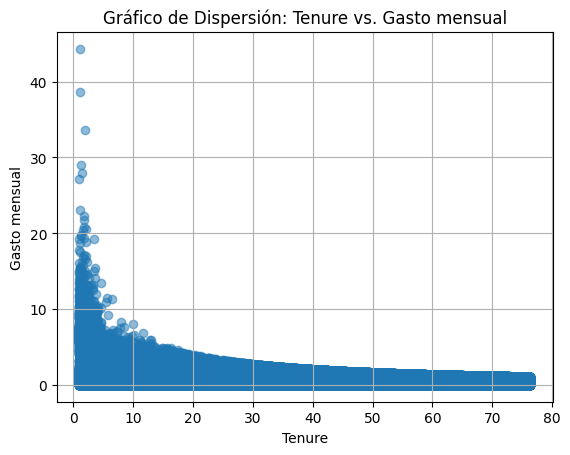

In [32]:
# Crear un gráfico de dispersión (scatter plot)
plt.scatter(df_b2['tenure'], df_b2['gasto_mensual'], alpha=0.5)

# Personalizar el gráfico
plt.title('Gráfico de Dispersión: Tenure vs. Gasto mensual')
plt.xlabel('Tenure')
plt.ylabel('Gasto mensual')
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [33]:

# Asegúrate de tener tu DataFrame df_2
# Puedes adaptar este código según la estructura real de tu DataFrame

# Calcular el rango intercuartílico (IQR) para 'gasto'
Q1 = df_b2['gasto_mensual'].quantile(0.25)
Q3 = df_b2['gasto_mensual'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para identificar outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Identificar índices de filas con outliers
indices_outliers = (df_b2['gasto_mensual'] < lower_limit) | (df_b2['gasto_mensual'] > upper_limit)

# Crear un nuevo DataFrame sin outliers
df_b2 =df_b2[(df_b2['gasto_mensual'] >= 0) & (~indices_outliers)]

# Mostrar el nuevo DataFrame sin outliers
print("DataFrame sin outliers en 'gasto mensual':")
print(df_b2)


DataFrame sin outliers en 'gasto mensual':
         account_id     tenure  churn        gasto  gasto_mensual  \
2           7249934       17.1      1   118.266450       0.230539   
3           6084398  25.866667      1    75.502918       0.097298   
4           7936556   9.066667      1    98.241612       0.361182   
6           7927768        9.2      1    20.729031       0.075105   
7           7202915  17.766667      1    22.470965       0.042159   
...             ...        ...    ...          ...            ...   
2291550    14343094   4.733333      1   184.030000       1.295986   
2291551    12076665  22.266667      1   703.880000       1.053713   
2291552    10951218       31.4      1  1272.600133       1.350956   
2291553    11957385  23.266667      1   697.070000       0.998668   
2291554    14018338   6.666667      1    46.280000       0.231400   

        nacionalidad  comunicaciones_agente  extranjero  
2             ESPANA                      0           0  
3           

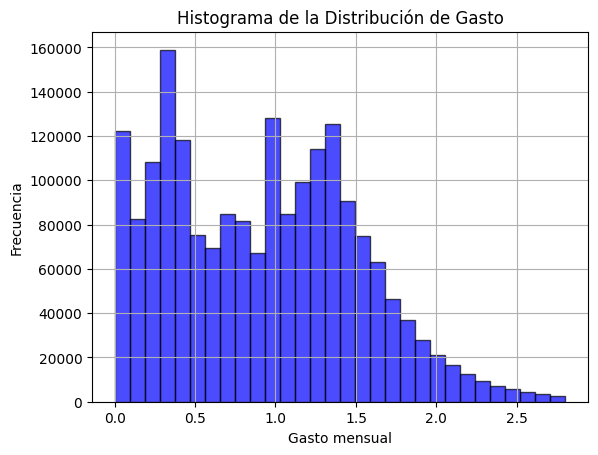

In [34]:
# Crear un histograma de la columna 'gasto'
plt.hist(df_b2['gasto_mensual'], bins=30, color='blue', edgecolor='black', alpha=0.7)

# Personalizar el gráfico
plt.title('Histograma de la Distribución de Gasto')
plt.xlabel('Gasto mensual')
plt.ylabel('Frecuencia')
plt.grid(True)

# Mostrar el gráfico
plt.show()

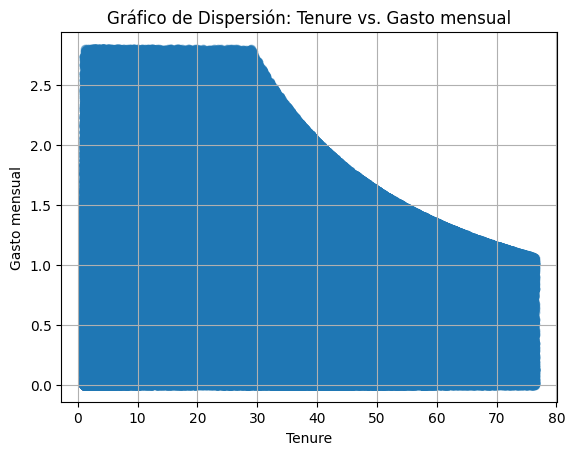

In [35]:
# Crear un gráfico de dispersión (scatter plot)
plt.scatter(df_b2['tenure'], df_b2['gasto_mensual'], alpha=0.5)

# Personalizar el gráfico
plt.title('Gráfico de Dispersión: Tenure vs. Gasto mensual')
plt.xlabel('Tenure')
plt.ylabel('Gasto mensual')
plt.grid(True)

# Mostrar el gráfico
plt.show()

####Comunicaciones con agente

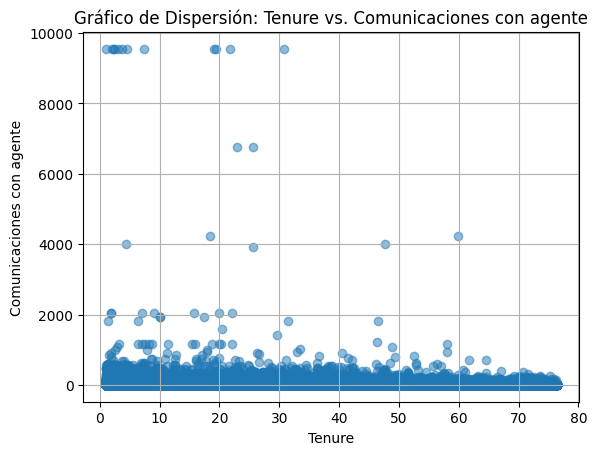

In [36]:
# Crear un gráfico de dispersión (scatter plot)
plt.scatter(df_b2['tenure'], df_b2['comunicaciones_agente'], alpha=0.5)

# Personalizar el gráfico
plt.title('Gráfico de Dispersión: Tenure vs. Comunicaciones con agente')
plt.xlabel('Tenure')
plt.ylabel('Comunicaciones con agente')
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [37]:

# Asegúrate de tener tu DataFrame df_2
# Puedes adaptar este código según la estructura real de tu DataFrame

# Calcular el rango intercuartílico (IQR) para 'gasto'
Q1 = df_b2['comunicaciones_agente'].quantile(0.25)
Q3 = df_b2['comunicaciones_agente'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para identificar outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Identificar índices de filas con outliers
indices_outliers = (df_b2['comunicaciones_agente'] < lower_limit) | (df_b2['comunicaciones_agente'] > upper_limit)

# Crear un nuevo DataFrame sin outliers
df_b2 =df_b2[(df_b2['comunicaciones_agente'] >= 0) & (~indices_outliers)]

# Mostrar el nuevo DataFrame sin outliers
print("DataFrame sin outliers en comunicaciones_agente:")
print(df_b2)


DataFrame sin outliers en comunicaciones_agente:
         account_id     tenure  churn        gasto  gasto_mensual  \
2           7249934       17.1      1   118.266450       0.230539   
3           6084398  25.866667      1    75.502918       0.097298   
4           7936556   9.066667      1    98.241612       0.361182   
6           7927768        9.2      1    20.729031       0.075105   
7           7202915  17.766667      1    22.470965       0.042159   
...             ...        ...    ...          ...            ...   
2291550    14343094   4.733333      1   184.030000       1.295986   
2291551    12076665  22.266667      1   703.880000       1.053713   
2291552    10951218       31.4      1  1272.600133       1.350956   
2291553    11957385  23.266667      1   697.070000       0.998668   
2291554    14018338   6.666667      1    46.280000       0.231400   

        nacionalidad  comunicaciones_agente  extranjero  
2             ESPANA                      0           0  
3     

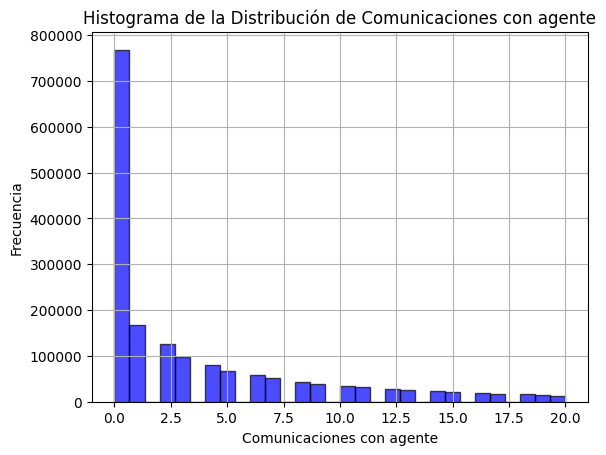

In [38]:
# Crear un histograma de la columna 'gasto'
plt.hist(df_b2['comunicaciones_agente'], bins=30, color='blue', edgecolor='black', alpha=0.7)

# Personalizar el gráfico
plt.title('Histograma de la Distribución de Comunicaciones con agente')
plt.xlabel('Comunicaciones con agente')
plt.ylabel('Frecuencia')
plt.grid(True)

# Mostrar el gráfico
plt.show()

####EXTRANJERO

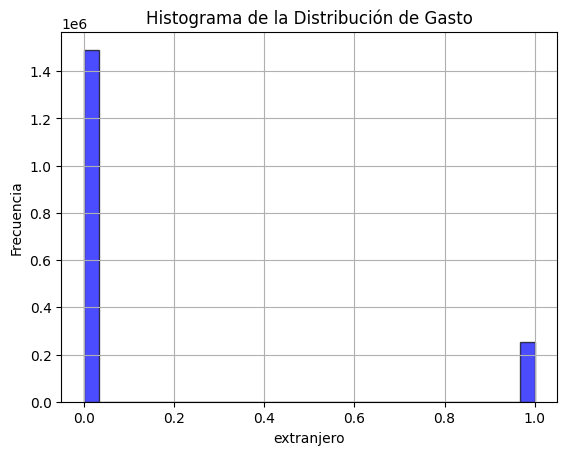

In [39]:
# Crear un histograma de la columna 'gasto'
plt.hist(df_b2['extranjero'], bins=30, color='blue', edgecolor='black', alpha=0.7)

# Personalizar el gráfico
plt.title('Histograma de la Distribución de Gasto')
plt.xlabel('extranjero')
plt.ylabel('Frecuencia')
plt.grid(True)

# Mostrar el gráfico
plt.show()

CORRELACIÓN

In [40]:
import pandas as pd
import numpy as np

# Calculamos la matriz de correlación
matriz_corr = df_b2[['tenure','gasto','gasto_mensual','comunicaciones_agente','extranjero']].corr()

# Establecemos un umbral de correlación para las variables
umbral = 0.85
umbral2 = -0.85

# Encontramos las variables correlacionadas entre sí
pares_variables = np.where((matriz_corr > umbral) | (matriz_corr < umbral2))
pares_variables = [(matriz_corr.index[x], matriz_corr.columns[y], matriz_corr.iloc[x, y]) for x, y in zip(*pares_variables) if x != y and x < y]

df_corr = pd.DataFrame(pares_variables, columns=['Variable 1', 'Variable 2', 'Correlación'])

# Mostramos las variables correlacionadas
display(df_corr)

# Ahora encontramos las variables no correlacionadas
pares_variables_nc = np.where((matriz_corr < 0.05) & (matriz_corr > -0.05))
pares_variables_nc = [(matriz_corr.index[x], matriz_corr.columns[y], matriz_corr.iloc[x, y]) for x, y in zip(*pares_variables_nc) if x != y and x < y]

df_corr_nc = pd.DataFrame(pares_variables_nc, columns=['Variable 1', 'Variable 2', 'Correlación'])

# Mostramos las variables no correlacionadas
display(df_corr_nc)


,Variable 1,Variable 2,Correlación


,Variable 1,Variable 2,Correlación
0,tenure,gasto_mensual,0.008345
1,comunicaciones_agente,extranjero,-0.028814


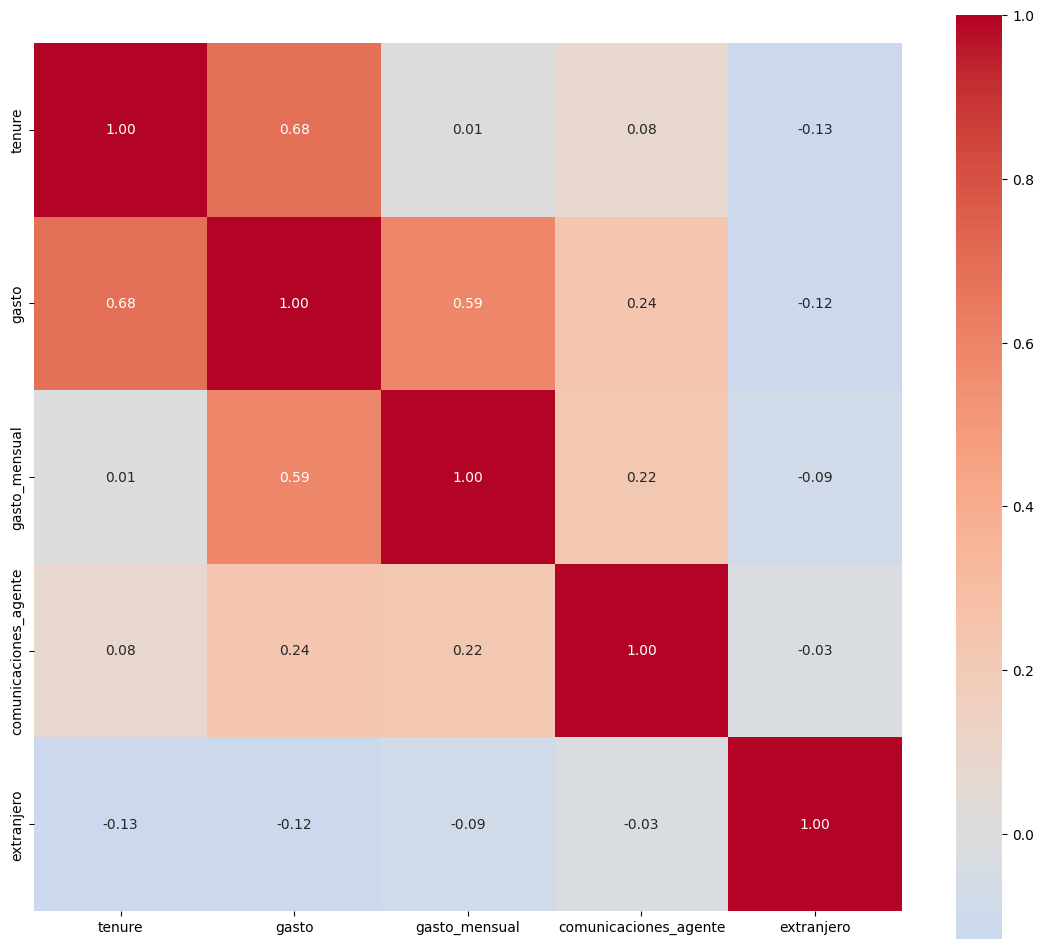

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creamos el heatmap con la matriz de correlación
plt.figure(figsize=(14, 12))
sns.heatmap(matriz_corr, cmap='coolwarm', center=0, square=True, annot=True, fmt='.2f')

# Muestra el heatmap
plt.show()


##Kaplan-Meier

In [42]:
kmf = KaplanMeierFitter()
T = df_b2['tenure'] #duration
C = df_b2["churn"] #censorship - 1 if death/churn is seen, 0 if censored
kmf.fit(T, event_observed=C)  # or, more succinctly, kmf.fit(T, C)

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1.74348e+06 total observations, 832439 right-censored observations>

###Función supervivencia global

Text(0.5, 1.0, 'Función de Supervivencia')

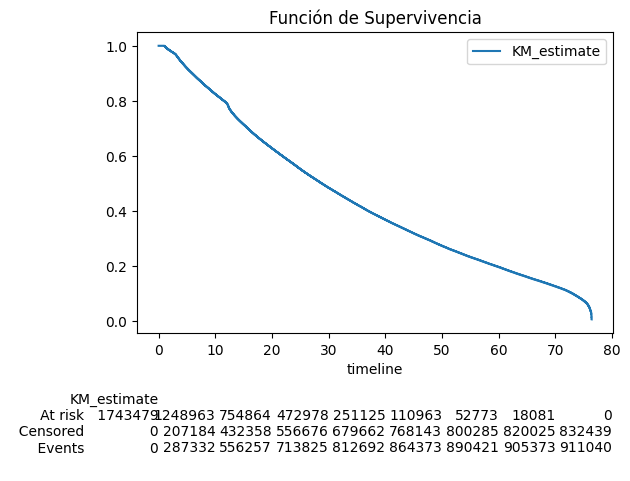

In [43]:
kmf.plot_survival_function(
    at_risk_counts=True
)
plt.title("Función de Supervivencia")

Text(0.5, 1.0, 'Función de densidad acumulada')

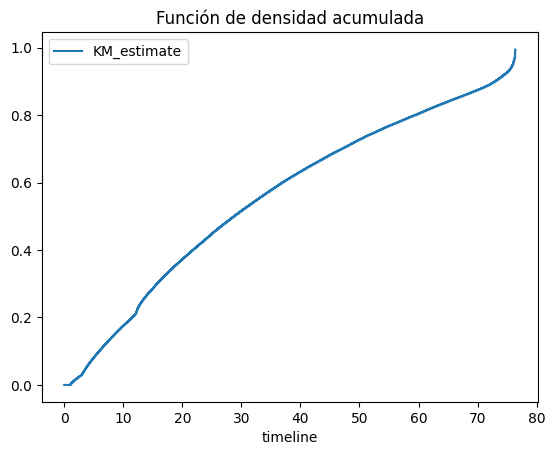

In [44]:
kmf.plot_cumulative_density()
plt.title("Función de densidad acumulada")

###Función de supervivencia por grupos

####GASTO

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


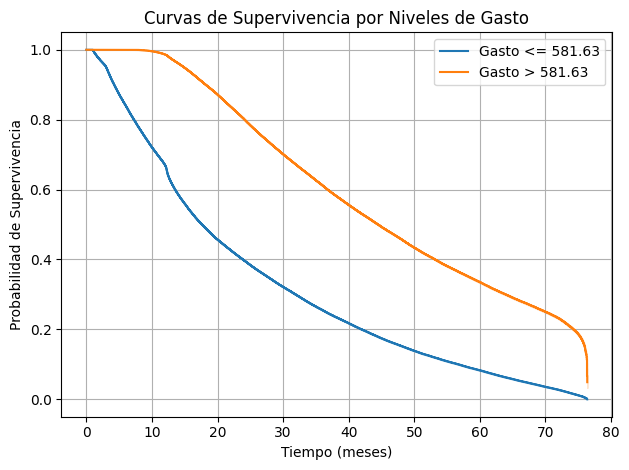

In [45]:

# 1. Calcular la media del valor de la variable 'gasto'
media_gasto = df_b2['gasto'].mean()

# 2. Dividir la muestra en dos grupos
group_0 = df_b2[df_b2['gasto'] <= media_gasto]
group_1 = df_b2[df_b2['gasto'] > media_gasto]

# 3. Ajustar el modelo de Kaplan-Meier para cada grupo
kmf = KaplanMeierFitter()

kmf.fit(group_0['tenure'], event_observed=group_0['churn'], label=f'Gasto <= {media_gasto.round(2)}')
ax = kmf.plot(ci_alpha=0.2, show_censors=False)

kmf.fit(group_1['tenure'], event_observed=group_1['churn'], label=f'Gasto > {media_gasto.round(2)}')
kmf.plot(ax=ax, ci_alpha=0.2, show_censors=False)

# 4. Personalizar el gráfico
plt.title("Curvas de Supervivencia por Niveles de Gasto")
plt.xlabel("Tiempo (meses)")
plt.ylabel("Probabilidad de Supervivencia")
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [46]:
# Realizar la prueba de log-rank
results_gasto = logrank_test(group_0['tenure'], group_1['tenure'], event_observed_A=group_0['churn'], event_observed_B=group_1['churn'])

# Imprimir el resultado del test de log-rank para 'gasto'
print("Resultado del test de Log-Rank para 'gasto':")
results_gasto.print_summary()

Resultado del test de Log-Rank para 'gasto':


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
      278839.22 <0.005       inf

####GASTO MENSUAL

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


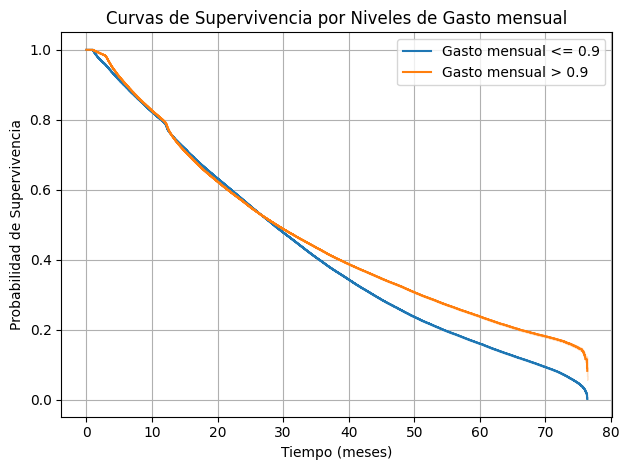

In [47]:

# 1. Calcular la media del valor de la variable 'gasto'
media_gasto = df_b2['gasto_mensual'].mean()

# 2. Dividir la muestra en dos grupos
group_0 = df_b2[df_b2['gasto_mensual'] <= media_gasto]
group_1 = df_b2[df_b2['gasto_mensual'] > media_gasto]

# 3. Ajustar el modelo de Kaplan-Meier para cada grupo
kmf = KaplanMeierFitter()

kmf.fit(group_0['tenure'], event_observed=group_0['churn'], label=f'Gasto mensual <= {media_gasto.round(2)}')
ax = kmf.plot(ci_alpha=0.2, show_censors=False)

kmf.fit(group_1['tenure'], event_observed=group_1['churn'], label=f'Gasto mensual > {media_gasto.round(2)}')
kmf.plot(ax=ax, ci_alpha=0.2, show_censors=False)

# 4. Personalizar el gráfico
plt.title("Curvas de Supervivencia por Niveles de Gasto mensual")
plt.xlabel("Tiempo (meses)")
plt.ylabel("Probabilidad de Supervivencia")
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [48]:
# Realizar la prueba de log-rank
results_gasto = logrank_test(group_0['tenure'], group_1['tenure'], event_observed_A=group_0['churn'], event_observed_B=group_1['churn'])

# Imprimir el resultado del test de log-rank para 'gasto'
print("Resultado del test de Log-Rank para 'gasto_mensual':")
results_gasto.print_summary()

Resultado del test de Log-Rank para 'gasto_mensual':


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2411.33 <0.005       inf

####COMUNICACIONES CON AGENTES

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


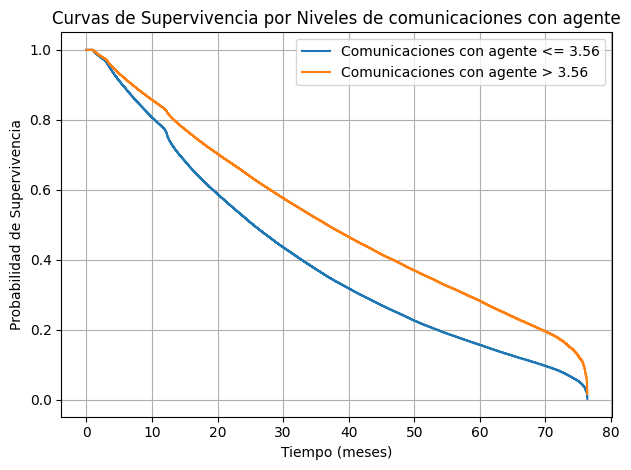

In [49]:

# 1. Calcular la media del valor de la variable 'gasto'
media_gasto = df_b2['comunicaciones_agente'].mean()

# 2. Dividir la muestra en dos grupos
group_0 = df_b2[df_b2['comunicaciones_agente'] <= media_gasto]
group_1 = df_b2[df_b2['comunicaciones_agente'] > media_gasto]

# 3. Ajustar el modelo de Kaplan-Meier para cada grupo
kmf = KaplanMeierFitter()

kmf.fit(group_0['tenure'], event_observed=group_0['churn'], label=f'Comunicaciones con agente <= {media_gasto.round(2)}')
ax = kmf.plot(ci_alpha=0.2, show_censors=False)

kmf.fit(group_1['tenure'], event_observed=group_1['churn'], label=f'Comunicaciones con agente > {media_gasto.round(2)}')
kmf.plot(ax=ax, ci_alpha=0.2, show_censors=False)

# 4. Personalizar el gráfico
plt.title("Curvas de Supervivencia por Niveles de comunicaciones con agente")
plt.xlabel("Tiempo (meses)")
plt.ylabel("Probabilidad de Supervivencia")
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [50]:
# Realizar la prueba de log-rank
results_gasto = logrank_test(group_0['tenure'], group_1['tenure'], event_observed_A=group_0['churn'], event_observed_B=group_1['churn'])

# Imprimir el resultado del test de log-rank para 'gasto'
print("Resultado del test de Log-Rank para 'comunicaciones con agente':")
results_gasto.print_summary()

Resultado del test de Log-Rank para 'comunicaciones con agente':


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
       28567.60 <0.005       inf

####EXTRANJERO

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


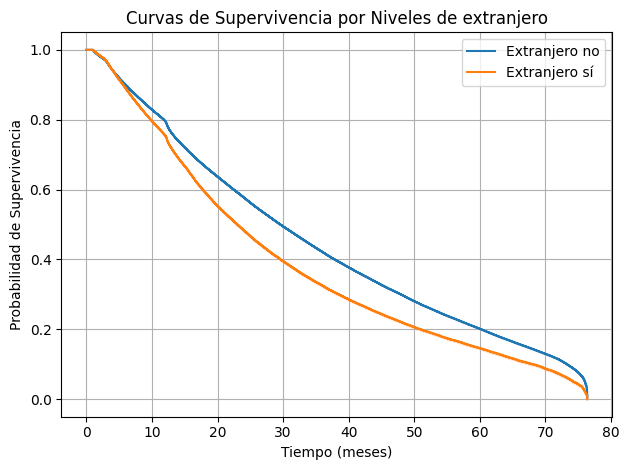

In [51]:

# 2. Dividir la muestra en dos grupos
group_0 = df_b2[df_b2['extranjero'] == 0]
group_1 = df_b2[df_b2['extranjero'] ==1]

# 3. Ajustar el modelo de Kaplan-Meier para cada grupo
kmf = KaplanMeierFitter()

kmf.fit(group_0['tenure'], event_observed=group_0['churn'], label=f'Extranjero no')
ax = kmf.plot(ci_alpha=0.2, show_censors=False)

kmf.fit(group_1['tenure'], event_observed=group_1['churn'], label=f'Extranjero sí')
kmf.plot(ax=ax, ci_alpha=0.2, show_censors=False)

# 4. Personalizar el gráfico
plt.title("Curvas de Supervivencia por Niveles de extranjero")
plt.xlabel("Tiempo (meses)")
plt.ylabel("Probabilidad de Supervivencia")
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [52]:
# Realizar la prueba de log-rank
results_gasto = logrank_test(group_0['tenure'], group_1['tenure'], event_observed_A=group_0['churn'], event_observed_B=group_1['churn'])

# Imprimir el resultado del test de log-rank para 'gasto'
print("Resultado del test de Log-Rank para 'comunicaciones con agente':")
results_gasto.print_summary()

Resultado del test de Log-Rank para 'comunicaciones con agente':


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        5320.48 <0.005       inf

#MODELO DE REGRESION DE COX

In [53]:
df_b2.dtypes

account_id                 Int64
tenure                   Float64
churn                      int64
gasto                    float64
gasto_mensual            float64
nacionalidad              object
comunicaciones_agente      Int64
extranjero                 int64
dtype: object

In [54]:
df_b2.head().T

,2,3,4,6,7
account_id,7249934,6084398,7936556,7927768,7202915
tenure,17.1,25.866667,9.066667,9.2,17.766667
churn,1,1,1,1,1
gasto,118.26645,75.502918,98.241612,20.729031,22.470965
gasto_mensual,0.230539,0.097298,0.361182,0.075105,0.042159
nacionalidad,ESPANA,ESPANA,ESPANA,ESPANA,ESPANA
comunicaciones_agente,0,0,2,0,0
extranjero,0,0,0,0,0


In [55]:
from lifelines import CoxPHFitter


cph = CoxPHFitter()
cph.fit(df_b2[['tenure','churn','gasto','gasto_mensual','comunicaciones_agente','extranjero']], duration_col = 'tenure', event_col = 'churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1.74348e+06 total observations, 832439 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 1.74348e+06
number of events observed = 911040
   partial log-likelihood = -11613908.72
         time fit was run = 2024-02-14 11:45:31 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
gasto                  -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
gasto_mensual           2.63      13.83       0.00             2.62             2.63                13.76                13.90
comunicaciones_agente  -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
extranjero              0.11       1.12       0.00             0.11             0.12                 1.11                 1.13

                        cmp to       z      p   -log2(p)
covariate                                               
gasto                     0.00 -923.64 <0.005        inf
gasto_mensual             0.00  993.88 <0.005        inf
comunicaciones_agente     0.00  -33.39 <0.005     809.40
extranjero                0.00   36.36 <0.005     958.95
---
Concordance = 0.88
Partial AIC = 23227825.44
log-likelihood ratio test = 1350561.53 on 4 df
-log2(p) of ll-ratio test = inf

<Axes: xlabel='log(HR) (95% CI)'>

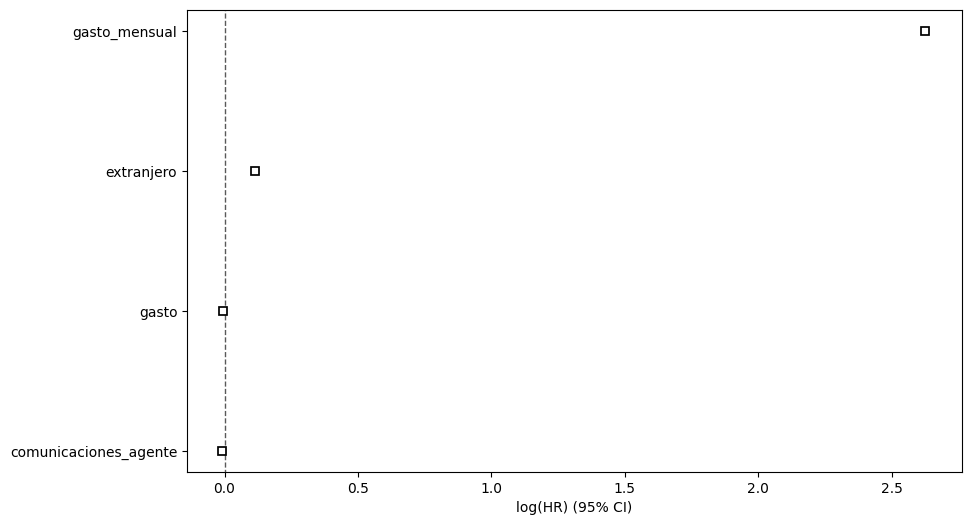

In [56]:
plt.subplots(figsize = (10, 6))
cph.plot()

In [57]:
# Razón de riesgos (Hazard Ratios)
hr = cph.hazard_ratios_
print(hr)

# Concordancia (C-index)
c_index = cph.concordance_index_
print(f"Concordance Index (C-index): {c_index}")


covariate
gasto                     0.996164
gasto_mensual            13.830154
comunicaciones_agente     0.992318
extranjero                1.120770
Name: exp(coef), dtype: float64
Concordance Index (C-index): 0.8752457905523982


In [58]:
#cph.check_assumptions(df_b2[['tenure','churn','gasto']], p_value_threshold = 0.05)

<Axes: >

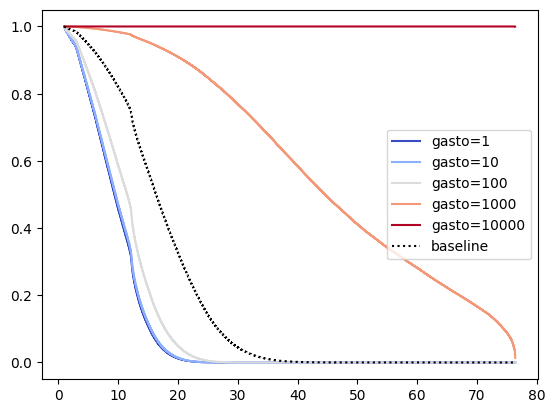

In [59]:
cph.plot_partial_effects_on_outcome(covariates = 'gasto', values = [1,10,100,1000,10000], cmap = 'coolwarm')

<Axes: >

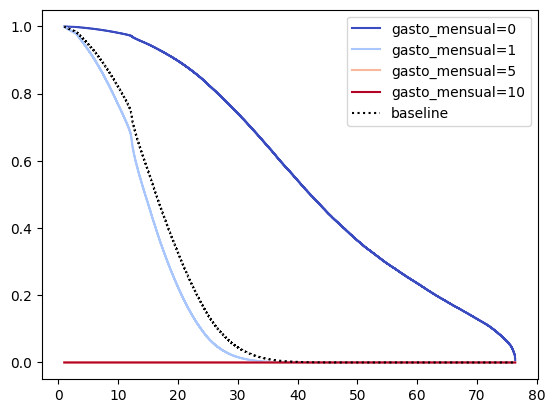

In [60]:
cph.plot_partial_effects_on_outcome(covariates = 'gasto_mensual', values = [0,1,5,10], cmap = 'coolwarm')

<Axes: >

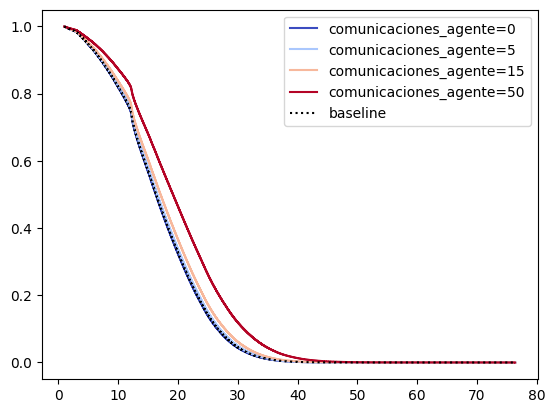

In [61]:
cph.plot_partial_effects_on_outcome(covariates = 'comunicaciones_agente', values = [0,5,15,50], cmap = 'coolwarm')

<Axes: >

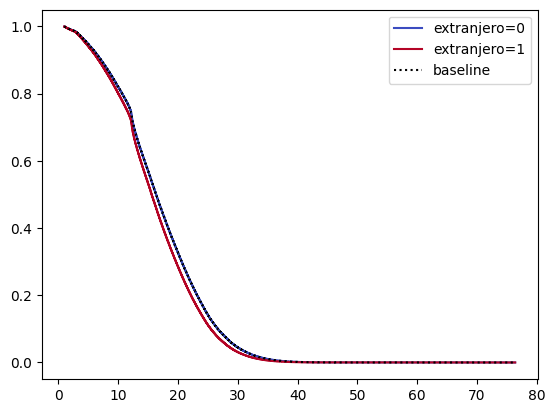

In [62]:
cph.plot_partial_effects_on_outcome(covariates = 'extranjero', values = [0,1], cmap = 'coolwarm')

#MODEL RANDOM SURVIVAL FOREST

In [63]:
pip install scikit-survival

  Using cached scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.0
    Uninstalling scikit-learn-1.4.0:
      Successfully uninstalled scikit-learn-1.4.0


In [64]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sklearn.model_selection import train_test_split

In [65]:
df_rsf= df_b2.copy()[['tenure','churn','gasto','gasto_mensual','comunicaciones_agente','extranjero']]
df_rsf_muestra = df_rsf.sample(n=10000, random_state=42)


In [66]:
y = Surv.from_arrays(df_rsf_muestra["churn"], df_rsf_muestra["tenure"])
X = df_rsf_muestra.drop(["churn", "tenure"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rsf = RandomSurvivalForest(n_estimators=100)
rsf.fit(X_train, y_train)

RandomSurvivalForest()

In [67]:
rsf.score(X_test, y_test)

0.8941070602054609

In [68]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=42)

pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
gasto,0.361037,0.007572
gasto_mensual,0.212135,0.005812
comunicaciones_agente,0.017274,0.002080
extranjero,0.000166,0.000992
